In [99]:
import pandas as pd
data=pd.read_csv('/Users/mihaimanu/Desktop/DICOM SAB/csf_sab_bci_CGN_JAX.csv')

In [100]:
from sklearn.preprocessing import RobustScaler

# Ensure each ptid has only one shunt value
assert data.groupby('ptid')['shunt'].nunique().max() == 1

# Columns to normalize
columns_to_normalize = ['cell', 'erys', 'protein']

# Initializing the RobustScaler
scaler = RobustScaler()

# Normalizing the data for each patient
normalized_data = data.copy()
for ptid in normalized_data['ptid'].unique():
    mask = normalized_data['ptid'] == ptid
    normalized_data.loc[mask, columns_to_normalize] = scaler.fit_transform(normalized_data.loc[mask, columns_to_normalize])

# Display the first few rows of the normalized data
normalized_data.head()

/var/folders/fx/dxrm77f54bd6mmt_d4yjy9x00000gn/T/ipykernel_68344/1533824834.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.   0.5 -1.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  normalized_data.loc[mask, columns_to_normalize] = scaler.fit_transform(normalized_data.loc[mask, columns_to_normalize])
/var/folders/fx/dxrm77f54bd6mmt_d4yjy9x00000gn/T/ipykernel_68344/1533824834.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.10864198  0.         -1.89135802]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  normalized_data.loc[mask, columns_to_normalize] = scaler.fit_transform(normalized_data.loc[mask, columns_to_normalize])


,day_since_sab,cell,erys,protein,shunt,ptid,BCI
0,2,0.000000,0.108642,0.000000,0,1,0.29
1,4,0.500000,0.000000,-0.772846,0,1,0.29
2,6,-1.500000,-1.891358,1.227154,0,1,0.29
3,2,-0.324242,0.000000,0.537415,0,2,0.20
4,3,0.675758,1.048534,1.326531,0,2,0.20


In [101]:
from scipy.stats import mannwhitneyu, kendalltau
import numpy as np

#  Sen's Slope
def sens_slope(x, y):
    n = len(x)
    slopes = [(y[j] - y[i]) / (x[j] - x[i]) for i in range(n) for j in range(i+1, n)]
    return np.median(slopes)

# Prepare a summary dictionary
summary_stats = {
    'ptid': [],
    'shunt': [],
    'mean_cell': [],
    'median_cell': [],
    'variance_cell': [],
    'mk_cell': [],
    'sens_cell': [],
    'mean_erys': [],
    'median_erys': [],
    'variance_erys': [],
    'mk_erys': [],
    'sens_erys': [],
    'mean_protein': [],
    'median_protein': [],
    'variance_protein': [],
    'mk_protein': [],
    'sens_protein': [],
}

#  statistics for each patient
for ptid, group in data.groupby('ptid'):
    summary_stats['ptid'].append(ptid)
    shunt_value = group['shunt'].iloc[0]
    summary_stats['shunt'].append(shunt_value)
    
    #would be nice to have the BCI for all patients in the series, just as an enhacing additional variable to the csf parameters
    #but i'll leave this out for now
    #BCI_value=group['BCI'].iloc[0]
    #summary_stats['BCI'].append(BCI_value)
    
    for feature in columns_to_normalize:
        values = group[feature].values
        time = group['day_since_sab'].values
        
        # stats
        summary_stats[f'mean_{feature}'].append(np.mean(values))
        summary_stats[f'median_{feature}'].append(np.median(values))
        summary_stats[f'variance_{feature}'].append(np.var(values))
        
        # Mann-Kendall Test and Sen's Slope
        mk_trend, _ = kendalltau(time, values)
        slope = sens_slope(time, values)
        summary_stats[f'mk_{feature}'].append(mk_trend)
        summary_stats[f'sens_{feature}'].append(slope)
        

# Convert summary into a DataFrame
summary_stats_df = pd.DataFrame(summary_stats)


comparison_results = {}
features = columns_to_normalize
stats = ['mean', 'median', 'variance', 'mk', 'sens']

#look for significant (p<0.05) features differing between shunt and no shunt conditions
for feature in features:
    for stat in stats:
        key = f'{stat}_{feature}'
        group0 = summary_stats_df[summary_stats_df['shunt'] == 0][key]
        group1 = summary_stats_df[summary_stats_df['shunt'] == 1][key]
        U_stat, p_val = mannwhitneyu(group0, group1, alternative='two-sided')
        comparison_results[f'{key}_p'] = p_val

comparison_results


{'mean_cell_p': 0.6948125771205129,
 'median_cell_p': 0.032745166343840226,
 'variance_cell_p': 0.7116152499259046,
 'mk_cell_p': 0.035163221958411324,
 'sens_cell_p': 0.10478219866697687,
 'mean_erys_p': 0.9218684577240204,
 'median_erys_p': 0.7455622441457364,
 'variance_erys_p': 0.838583699742677,
 'mk_erys_p': 0.007948070026661064,
 'sens_erys_p': 0.007398604942678309,
 'mean_protein_p': 0.5921867577683525,
 'median_protein_p': 0.1996108632626119,
 'variance_protein_p': 0.6892550598968346,
 'mk_protein_p': 0.1993713496573729,
 'sens_protein_p': 0.12938895700105163}

Random Forest Classifier Report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.67      0.50      0.57         4

    accuracy                           0.75        12
   macro avg       0.72      0.69      0.70        12
weighted avg       0.74      0.75      0.74        12

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.75      0.75      0.75         4

    accuracy                           0.83        12
   macro avg       0.81      0.81      0.81        12
weighted avg       0.83      0.83      0.83        12

Matthews Correlation Coefficient for Random Forest: 0.41
Matthews Correlation Coefficient for Logistic Regression: 0.62


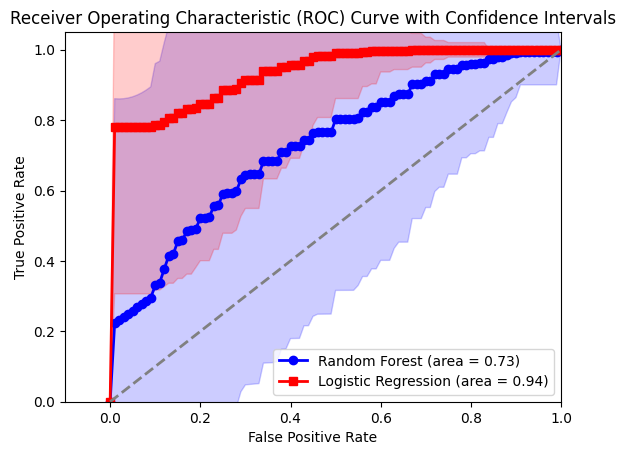

Coefficients (lr): [[ 4.74210380e-01 -1.39859323e-04]]
Optimization terminated successfully.
         Current function value: 0.600813
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  shunt   No. Observations:                   60
Model:                          Logit   Df Residuals:                       57
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 May 2024   Pseudo R-squ.:                  0.1073
Time:                        11:03:18   Log-Likelihood:                -36.049
converged:                       True   LL-Null:                       -40.381
Covariance Type:            nonrobust   LLR p-value:                   0.01314
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3952      0.460      0.860      0

In [133]:

#this is the main block of code that does model training and 

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm5

# Identifying variables with p-values less than 0.01 from the previous calculation, chnage value for more variables
significant_vars = [key.replace('_p', '') for key, value in comparison_results.items() if value < 0.05]

# additional imaging variable (again for later enhancements)
#ct_vars = ['BCI']
#significant_vars.append('BCI')
#X_significant = summary_stats_df[significant_vars]

X_significant_LR=summary_stats_df[['mk_erys', 'median_cell']]# I settled for these 2 while mk_erys and sens_erys are most likely correlated
#thus introducing a multicollinearity that degrades the perfomance of the LR models. The choice for mk was based on our (Cologne) series where
#the shunt proportion was more inline with the literature at large

X_significant_RF=summary_stats_df[significant_vars] #RF models suffer less from multicollinearity, hence I took all the significant parameters
#as defined by their p values in the previous step
y = summary_stats_df['shunt']

#scaler = MinMaxScaler()
#X_significant['BCI'] = scaler.fit_transform(X_significant[['BCI']])

# Initializing the Random Forest Classifier and Logistic Regression
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
lr = LogisticRegression(multi_class='multinomial', class_weight='balanced', penalty='l2', C=1.0, solver='lbfgs', random_state=42, max_iter=5000)

#alternnatively using LogisticRegressionCV with L1 penalty to improve the pseudo-rsquared
#lr_elastic = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1.0, solver='saga', class_weight='balanced', multi_class='multinomial', random_state=42, max_iter=5000)

# Splitting the data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_significant_RF, y, test_size=0.2, random_state=42)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_significant_LR, y, test_size=0.2, random_state=42)

# Training the Random Forest Classifier and Logistic Regression
rf.fit(X_train_rf, y_train_rf)
lr.fit(X_train_lr, y_train_lr)
#lr_elastic.fit(X_train_lr, y_train_lr)

# Predicting on the test set
y_pred_rf = rf.predict(X_test_rf)
y_pred_lr = lr.predict(X_test_lr)

# Generating a classification report for the Random Forest model
report_rf = classification_report(y_test_rf, y_pred_rf)
report_lr = classification_report(y_test_lr, y_pred_lr)

print("Random Forest Classifier Report:\n", report_rf)
print("Logistic Regression Report:\n", report_lr)

#Matthews correlation coefficient for evaluatin the performance of binary classification
#in datasets with imbalanced classes, values between -1 to 1, the range 0.4 to 0.7 considered good performance 
mcc_rf = matthews_corrcoef(y_test_rf, y_pred_rf)
mcc_lr = matthews_corrcoef(y_test_lr, y_pred_lr)

print(f"Matthews Correlation Coefficient for Random Forest: {mcc_rf:.2f}")
print(f"Matthews Correlation Coefficient for Logistic Regression: {mcc_lr:.2f}")

# Calculating the probabilities for the positive class
y_pred_prob_rf = rf.predict_proba(X_test_rf)[:, 1]
y_pred_prob_lr = lr.predict_proba(X_test_lr)[:, 1]

# Compute ROC curve and ROC area for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Compute ROC curve and ROC area for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

y_test_rf=np.array(y_test_rf)
y_test_lr=np.array(y_test_lr)

# Bootstrapping to calculate confidence intervals
n_bootstraps = 1000
rng = np.random.RandomState(42)
tprs_rf = []
tprs_lr = []
base_fpr = np.linspace(0, 1, 101)

for i in range(n_bootstraps):
    indices = rng.randint(0, len(y_test_rf), len(y_test_rf))
    if len(np.unique(y_test_rf[indices])) < 2:
        continue

    # Bootstrap for Random Forest
    y_test_boot = y_test_rf[indices]
    y_pred_prob_boot = y_pred_prob_rf[indices]
    fpr, tpr, _ = roc_curve(y_test_boot, y_pred_prob_boot)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_rf.append(tpr)

    # Bootstrap for Logistic Regression
    y_test_boot = y_test_lr[indices]
    y_pred_prob_boot = y_pred_prob_lr[indices]
    fpr, tpr, _ = roc_curve(y_test_boot, y_pred_prob_boot)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs_lr.append(tpr)

# Calculating mean and standard deviation of TPRs for confidence intervals
mean_tprs_rf = np.mean(tprs_rf, axis=0)
std_tprs_rf = np.std(tprs_rf, axis=0)
mean_tprs_lr = np.mean(tprs_lr, axis=0)
std_tprs_lr = np.std(tprs_lr, axis=0)

# Plotting the ROC curve with CI as well as diagonal reference line
plt.figure()
plt.plot(base_fpr, mean_tprs_rf, color='blue', marker='o', linestyle='-', lw=2, label=f'Random Forest (area = {roc_auc_rf:.2f})')
plt.fill_between(base_fpr, mean_tprs_rf - 1.96*std_tprs_rf, mean_tprs_rf + 1.96*std_tprs_rf, color='blue', alpha=0.2)
plt.plot(base_fpr, mean_tprs_lr, color='red', marker='s', linestyle='-', lw=2, label=f'Logistic Regression (area = {roc_auc_lr:.2f})')
plt.fill_between(base_fpr, mean_tprs_lr - 1.96*std_tprs_lr, mean_tprs_lr + 1.96*std_tprs_lr, color='red', alpha=0.2)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Confidence Intervals')
plt.legend(loc="lower right")
plt.savefig('roc with CI', dpi=300)
plt.show()

# Print coefficients of the sklearn Logistic Regression model
print("Coefficients (lr):", lr.coef_)

# Adding a constant for the intercept
X_significant_sm = sm.add_constant(X_significant_LR)

# Fit the logistic regression model using statsmodels
model_sm = sm.Logit(y, X_significant_sm).fit()

# Display the summary which includes coefficients, p-values, etc.
print(model_sm.summary())

# Calculate and display odds ratios
odds_ratios = np.exp(model_sm.params)
print("\nOdds Ratios:")
print(odds_ratios)

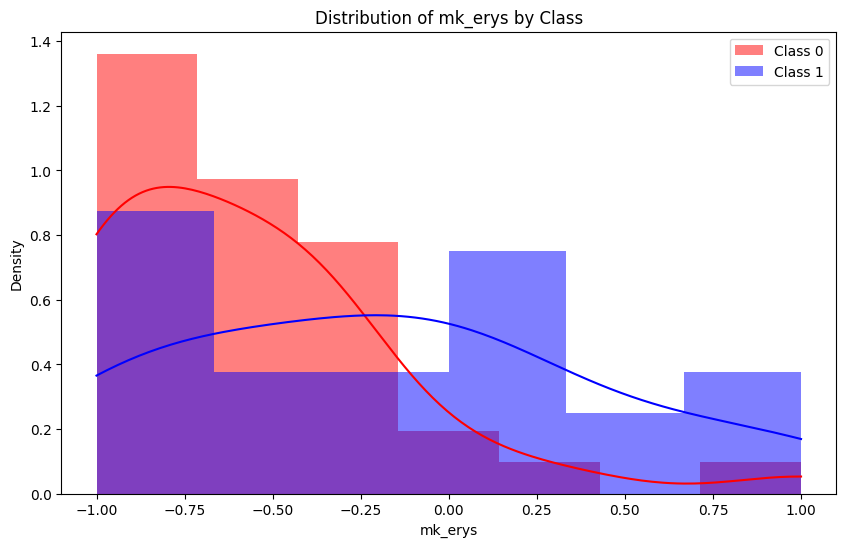

/Users/mihaimanu/Library/Python/3.10/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


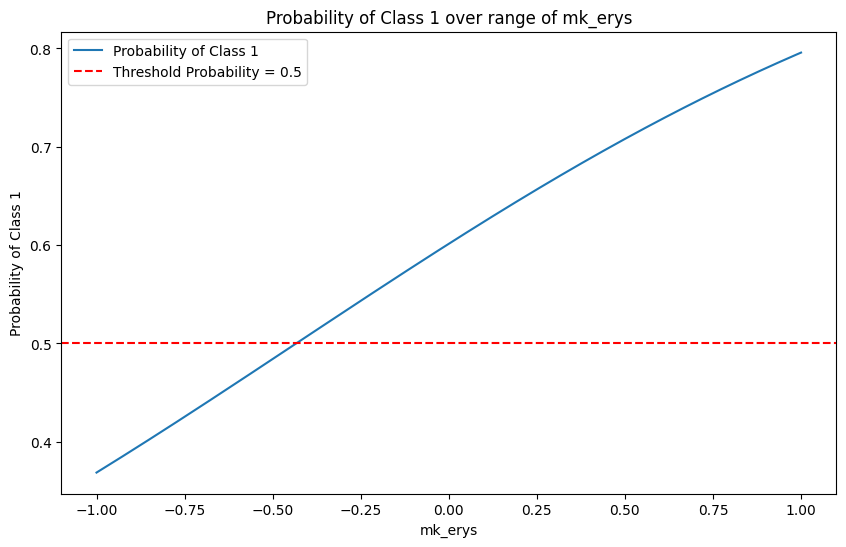

Estimated threshold value of mk_erys to separate the classes in the normalized data is approximately -0.43
Raw threshold value of mk_erys to separate the classes is approximately -0.89


In [135]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# using the split data from previous block and looking for the threshold values of the mk_erys that best separates the class shunt
#from class not shunt

# Visualizing distributions of 'mk_erys' for each class, rember this is after scaling/normalizing the raw data!
plt.figure(figsize=(10, 6))
sns.histplot(summary_stats_df[summary_stats_df['shunt'] == 0]['mk_erys'], color="red", label="Class 0", kde=True, stat="density", linewidth=0)
sns.histplot(summary_stats_df[summary_stats_df['shunt'] == 1]['mk_erys'], color="blue", label="Class 1", kde=True, stat="density", linewidth=0)
plt.legend()
plt.title('Distribution of mk_erys by Class')
plt.xlabel('mk_erys')
plt.ylabel('Density')
plt.show()

# Generating a range of values for 'mk_erys' from its min to max value
mk_erys_range = np.linspace(summary_stats_df['mk_erys'].min(), summary_stats_df['mk_erys'].max(), 300)

# Replace 'median_cell' with its mean or median value as it won't change across the range
median_cell_value = summary_stats_df['median_cell'].median()
X_test_range = np.column_stack((mk_erys_range, np.full(mk_erys_range.shape, median_cell_value)))

# Predict probabilities for the range of 'mk_erys'
probs = lr.predict_proba(X_test_range)[:, 1]  #class 1 probabilities are at index 1

# Plotting probabilities over 'mk_erys' range to find threshold 
plt.figure(figsize=(10, 6))
plt.plot(mk_erys_range, probs, label='Probability of Class 1')
plt.axhline(0.5, color='red', linestyle='--', label='Threshold Probability = 0.5')
plt.title('Probability of Class 1 over range of mk_erys')
plt.xlabel('mk_erys')
plt.ylabel('Probability of Class 1')
plt.legend()
plt.show()

# Find the closest index where the probability crosses 0.5
threshold_index = np.abs(probs - 0.5).argmin()
threshold_value = mk_erys_range[threshold_index]
print(f"Estimated threshold value of mk_erys to separate the classes in the normalized data is approximately {threshold_value:.2f}")

#revert to rawa data format for real life implementation based on the RobustScaler reverse formula
median_mk_erys = np.median(summary_stats['mk_erys']) 
Q1_mk_erys = np.percentile(summary_stats['mk_erys'], 25)
Q3_mk_erys = np.percentile(summary_stats['mk_erys'], 75)
IQR_mk_erys = Q3_mk_erys - Q1_mk_erys

raw_threshold = threshold_value * IQR_mk_erys + median_mk_erys

print(f"Raw threshold value of mk_erys to separate the classes is approximately {raw_threshold:.2f}")


In [136]:
import shap
explainer=shap.TreeExplainer(rf)
shap_values=explainer.shap_values(X_test_rf)

SHAP Values Shape: (12, 4)
X_test_rf Shape: (12, 4)


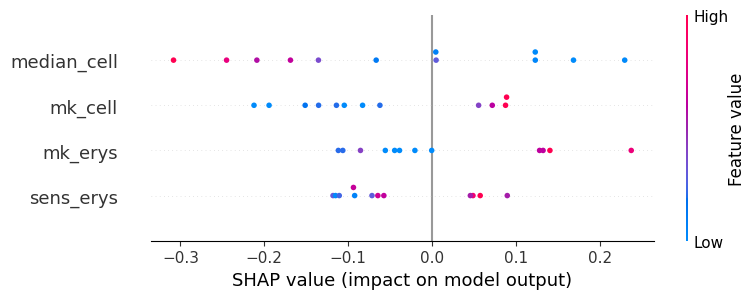

In [137]:
# Check if it's binary or multi-class classification
if isinstance(shap_values, list) or shap_values.ndim == 3:
    shap_values = shap_values[:, :, 1]  # For binary classification, get the SHAP values for the positive class

# Print SHAP values shape for diagnostics
print(f"SHAP Values Shape: {shap_values.shape}")
print(f"X_test_rf Shape: {X_test_rf.shape}")

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test_rf, show=False)
fig=plt.gcf()
fig.savefig('shap_summary.png',bbox_inches='tight', dpi=300)


In [138]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report, roc_auc_score

# Confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)
print("Confusion Matrix for Random Forest:\n", conf_matrix_rf)

# Precision, Recall, F1-score and MCC for Random Forest
print("Classification Report for Random Forest:\n", classification_report(y_test_rf, y_pred_rf))
mcc_rf = matthews_corrcoef(y_test_rf, y_pred_rf)
print(f"Matthews Correlation Coefficient for Random Forest: {mcc_rf:.2f}")

# AUC for Random Forest
auc_rf = roc_auc_score(y_test_rf, y_pred_prob_rf)
print(f"AUC for Random Forest: {auc_rf:.2f}")

# Confusion matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_test_lr, y_pred_lr)
print("Confusion Matrix for Logistic Regression:\n", conf_matrix_lr)

# Precision, Recall, F1-score and MCC for Logistic Regression
print("Classification Report for Logistic Regression:\n", classification_report(y_test_lr, y_pred_lr))
mcc_lr = matthews_corrcoef(y_test_lr, y_pred_lr)
print(f"Matthews Correlation Coefficient for Logistic Regression: {mcc_lr:.2f}")

# AUC for Logistic Regression
auc_lr = roc_auc_score(y_test_lr, y_pred_prob_lr)
print(f"AUC for Logistic Regression: {auc_lr:.2f}")


Confusion Matrix for Random Forest:
 [[7 1]
 [2 2]]
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.67      0.50      0.57         4

    accuracy                           0.75        12
   macro avg       0.72      0.69      0.70        12
weighted avg       0.74      0.75      0.74        12

Matthews Correlation Coefficient for Random Forest: 0.41
AUC for Random Forest: 0.73
Confusion Matrix for Logistic Regression:
 [[7 1]
 [1 3]]
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.75      0.75      0.75         4

    accuracy                           0.83        12
   macro avg       0.81      0.81      0.81        12
weighted avg       0.83      0.83      0.83        12

Matthews Correlation Coefficient for Logistic Regression: 0.6

In [79]:
Q1=df.quantile(0.25)

In [80]:
Q3=df.quantile(0.75)

In [81]:
IQR=Q3-Q1
outliers=((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))
print(outliers)

     day_since_sab   cell   erys  protein  shunt  lactic_acid   ptid    BCI
0            False  False  False    False  False        False  False  False
1            False  False  False    False  False        False  False  False
2            False  False  False    False  False        False  False  False
3            False  False  False    False  False        False  False  False
4            False  False  False    False  False        False  False  False
..             ...    ...    ...      ...    ...          ...    ...    ...
203          False  False  False    False  False        False  False  False
204          False  False  False    False  False        False  False  False
205          False  False   True    False  False        False  False  False
206          False   True   True    False  False        False  False  False
207          False  False  False    False  False        False  False  False

[208 rows x 8 columns]


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Accuracy: 0.83
Precision: 1.00
Recall: 0.50
F1 Score: 0.67
ROC AUC: 0.70
Brier Score Loss: 0.21
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.50      0.67         4

    accuracy                           0.83        12
   macro avg       0.90      0.75      0.78        12
weighted avg       0.87      0.83      0.81        12



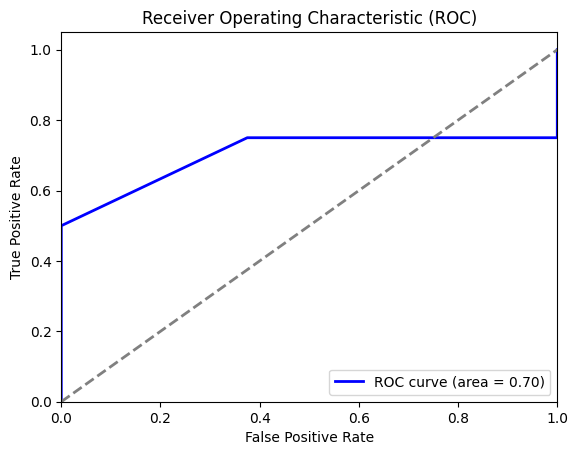

In [154]:
#just for fun, a multi-layer perceptron with optimized hyperparameters after grid search, lackluster performance

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, classification_report, brier_score_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import shap
import seaborn as sns

#X_significant_mlp=list(summary_stats_df.columns)
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_significant_RF, y, test_size=0.2, random_state=42)

# Define the parameter grid, one hidden layer of 10, 50 and 100 nodes
param_grid = {
    'hidden_layer_sizes': [(10,5), (25,10), (50,25)],  #change this line to play with the number of neurons in each layer as well as number of layers
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [5000]
}

# Initialize your MLPClassifier
mlp = MLPClassifier(random_state=42)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(X_significant_RF, y)
mlp_best = grid_search.best_estimator_


# Fit the model to the training data
mlp_best.fit(X_train_mlp, y_train_mlp)
y_pred_mlp = mlp_best.predict(X_test_mlp)
y_pred_prob_mlp = mlp_best.predict_proba(X_test_mlp)[:, 1] 

# evaluation metrics
accuracy = accuracy_score(y_test_mlp, y_pred_mlp)
precision = precision_score(y_test_mlp, y_pred_mlp)
recall = recall_score(y_test_mlp, y_pred_mlp)
f1 = f1_score(y_test_mlp, y_pred_mlp)
roc_auc = roc_auc_score(y_test_mlp, y_pred_prob_mlp)
#brier_loss = brier_score_loss(y_test_mlp, y_pred_prob_mlp)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print(f"Brier Score Loss: {brier_loss:.2f}")

# Print classification report
print(classification_report(y_test_mlp, y_pred_mlp))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_mlp, y_pred_prob_mlp)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()